# 财务欺诈预测

财务欺诈是一个全球性的重要问题。 如果不及时发现和预防，可能会对欺诈公司（eg. Enron)的利益相关者以及许多非欺诈性公司的利益相关者造成间接伤害(Gleason, Jenkins, and Johnson [2008], Goldman, Peyer, and Stefanescu [2012], Hung, Wong, and Zhang [2015])。在本节中的学习中，我们使用ML方法来预测中国市场的财务欺诈行为。

我们将收集一些关键的财务数据用来预测财务欺诈行为。首先，财务数据是公司状况的晴雨表，财务信息中包含了公司基本面的绝大部分情况。第二，基于公开可用财务数据的欺诈预测模型可以低成本应用于任何公开交易的公司。第三，现有会计文献中的大多数欺诈预测模型也依赖于公开可用的财务数据。

## 一、	数据

### A.	欺诈数据

从CSMAR数据库中下载财务违规信息，具体路径为：

公司研究系列 – 会计信息质量 – 财务报告信息 – 财务违规 – 上市公司财务违规表（日）

# 1)	问题1：找出公司的财务违规年份和违规类型及相应处罚，生成一个新的数据集（每列对应：公司ID、违规年份、违规类型、相应处罚），列名自取。

In [60]:
import pandas as pd
import numpy as np
from imblearn.ensemble import RUSBoostClassifier
from sklearn.linear_model.logistic import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [61]:
os.chdir(r'D:\Postgraduate\2020\财务欺诈')
fraud = pd.read_csv('AIQ_LCFinViolationD.csv',sep=',', error_bad_lines=False)

b'Skipping line 147: expected 16 fields, saw 18\nSkipping line 152: expected 16 fields, saw 18\nSkipping line 218: expected 16 fields, saw 23\nSkipping line 225: expected 16 fields, saw 17\nSkipping line 234: expected 16 fields, saw 21\nSkipping line 458: expected 16 fields, saw 31\nSkipping line 754: expected 16 fields, saw 21\nSkipping line 802: expected 16 fields, saw 87\nSkipping line 842: expected 16 fields, saw 42\n'


In [4]:
fraud

,Symbol,ViolationID,DeclareDate,ShortName,DisposalDate,Promulgator,FileName,DocumentNumber,Supervisor,ViolationType,Law,ViolationYear,Activity,PunishmentMeasure,PunishmentType,Penalty
0,805,4043,2012-12-15,*ST 炎黄,2012-12-12,上市公司,关于收到中国证券监督管理委员会《行政处罚决定书》的公告,[2012]48号,中国证监会,"P2501,P2505",违反了《证券法》第六十三条的规定，构成了《证券法》第一百九十三条所述的行为。王云、何为民、陈...,2006,（一）未按规定披露关联关系及关联交易 炎黄在线2006年年度报告中未将高能控股有限公司（以...,根据当事人违法行为的事实、性质、情节与社会危害程度，依据《证券法》第一百九十三条的规定，中国...,"P2602,P2604",300000.0
1,600236,4046,2012-12-15,桂冠电力,2012-12-12,上市公司,收到责令改正措施决定书的公告,【2012】5号,其他(广西证监局),"P2504,P2505,P2510,P2515,P2599",不符合《企业会计准则》关于在建工程在达到预定可使用状态时即应结转固定资产并按规定计提折旧的规...,"2010,2011,2012","一、公司部分关联方和关联交易确认、披露不完整,部分重大事项未及时履行信息披露义务 (一)公...",在收到《决定书》的30日内披露相关整改方案，并按要求在2013年5月7日前完成整改工作。,P2699,NaN
2,600365,404,2012-12-27,通葡股份,2012-12-26,上市公司,关于近五年监管部门监管关注事项及整改情况的公告,"[2010]04号,吉证监函[2012]95号",其他(吉林证监局),"P2503,P2504,P2515,P2599",NaN,"2007,2009,2010,2011,2012",（一）规范运作方面问题 1、公司“三会”资料的规范性和完整性尚需提高，部分股东大会会议记录...,NaN,P2699,NaN
3,601678,403855,2012-03-01,滨化股份,2012-02-07,上市公司,关于山东监管局现场检查相关问题的整改报告,[2012]1号,其他(中国证监会山东监管局),"P2503,P2505,P2515,P2599",NaN,"2009,2010,2011,2012",一、规范运作方面存在的问题(一)股东大会运作存在的问题1.部分股东大会未记载出席会议的股东和...,NaN,P2699,NaN
4,711,403861,2011-11-23,天伦置业,2011-11-18,上市公司,关于收到黑龙江监管局责令改正决定书的公告,[2011]18号,其他(黑龙江证监局),"P2503,P2515",NaN,2011,一、内控制度建立健全情况1、缺少《外部信息使用人管理制度》。2、缺少《年报信息披露重大差错责...,NaN,P2699,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,2535,4081721,2020-10-30,*ST 林重,2020-10-30,深圳证券交易所,关于对林州重机集团股份有限公司及相关当事人给予通报批评处分的决定,NaN,深圳证券交易所,"P2501,P2502,P2503,P2504,P2599","违反了本所《股票上市规则(2014年修订)》第1.4条、第2.1条,本所《股票上市规则(20...","2018,2019,2020","经查明,林州重机集团股份有限公司(以下简称“林州重机”)及相关当事人存在以下违规行为:一、2...","鉴于上述违规事实及情节,依据本所《股票上市规则(2014年修订)》第17.2条、第17.3条...",P2601,NaN
869,2411,4081799,2020-11-03,延安必康,2020-10-30,上市公司,关于收到中国证券监督管理委员会陕西监管局《行政监管措施决定书》的公告,"陕证监措施字[2020]29号,陕证监措施字[2020]31号",其他(中国证监会陕西监管局),"P2501,P2503,P2510,P2515,P2599","不符合《企业内部控制基本规范》(财会[2008]7号)第三条、第三十一条第一款,《上市公司治...","2015,2016,2017,2018,2019","延安必康制药股份有限公司:经查,2015年至2018年期间,你公司通过虚假财务记账等手段掩盖...","根据《上市公司现场检查办法》(证监会公告[2010]12号)第二十一条的规定,我局决定对你公...",P2699,NaN
870,2213,4081800,2020-11-03,大为股份,2020-11-02,上市公司,关于收到深圳证监局行政监管措施决定书的公告,[2020]173号,其他(深圳证监局),P2515,"不符合《企业会计准则第16号—政府补助》第八条的相关规定,不符合《企业会计准则第6号—无形资...","2017,2019",一、存货跌价测试不审慎(一)未严格按照会计政策进行存货跌价测试你公司在对存货进行跌价测试时未...,"根据《上市公司现场检查办法》第二十一条、《上市公司信息披露管理办法》第五十九条等规定,我局决...",P2699,NaN
871,2823,4081839,2020-11-03,凯中精密,2020-11-03,深圳证券交易所,关于对深圳市凯中精密技术股份有限公司的监管函,中小板监管函【2020】第139号,深圳证券交易所,P2515,违反了本所《股票上市规则(2018年11月修订)》第1.4条和第2.1条的规定。,2020,"2020年10月29日,你公司披露《关于2020年半年度报告全文及摘要的更正公告》称,因财务...",整改。,P2699,NaN


In [3]:
# define a split function
def get_fraud(attention):
    fraud_split = fraud[attention].str.split(',',expand=True)
    fraud_split.index = fraud['Symbol']
    temp = fraud_split.stack().reset_index().rename(columns={0:attention})
    final = temp[['Symbol', attention]]
    final['isFraud'] = 1
    return final

fraud_year = get_fraud('ViolationYear').drop_duplicates()
fraud_type = get_fraud('ViolationType')
fraud_punish = get_fraud('PunishmentType')

In [4]:
fraud_year

,Symbol,ViolationYear,isFraud
0,805,2006,1
1,600236,2010,1
2,600236,2011,1
3,600236,2012,1
4,600365,2007,1
...,...,...,...
2198,2535,2020,1
2204,2213,2017,1
2205,2213,2019,1
2206,2823,2020,1


In [12]:
#set a new dataframe
type1 = pd.pivot_table(fraud_type, index='Symbol', columns='ViolationType')['isFraud']
punish1 = pd.pivot_table(fraud_punish, index='Symbol', columns='PunishmentType')['isFraud']
com = pd.concat([type1, punish1], axis=1).reset_index()
new_data = pd.merge(fraud_year, com, how='left', on='Symbol')

In [25]:
new_data

,Symbol,ViolationYear,isFraud,P2501,P2502,P2503,P2504,P2505,P2506,P2507,...,P2512,P2514,P2515,P2599,P2601,P2602,P2603,P2604,P2605,P2699
0,805,2006,1,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
1,600236,2010,1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
2,600236,2011,1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
3,600236,2012,1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
4,600365,2007,1,NaN,NaN,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,2535,2020,1,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0
1876,2213,2017,1,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
1877,2213,2019,1,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
1878,2823,2020,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### B.	财务数据

Bao et al. (2020)认为基于潜在的不完整行为理论将原始会计数据转换为有限数量的财务比率可能意味着有用的预测信息丢失。因此，在相同的方法下，我们要求比较原始财务数据项和财务比率两种数据在预测中的性能。此时我们的样本为全A股上市公司。

#### 1. 收集20从财务报表中获取的原始财务数据作为欺诈预测指标。

利润表--营业收入/营业成本/营业税金及附加/营业利润/利润总额/净利润

资产负债表--交易性金融资产/应收账款/存货/固定资产/流动资产/总资产/流动负债/权益/应付账款/应交税费

现金流量表--现金及现金等价物/经营活动现金流/投资活动现金流/融资活动现金流

#### 2. 计算财务比率

ACC: 利润总额减去营业现金流，除以平均资产合计,平均资产合计等于 t-12 月份和 t 月份的总资产平均值

Change in receivables: 应收账款变动 / 平均资产合计

Change in inventory: 存货变动 / 平均资产合计

Soft Assets: (总资产 - 固定资产 – 现金及现金等价物 ) / 总资产

Change in cash sales: 营业收入 - 应收账款变动 

Percentage change in cash margin, where cash margin is measured as 1 - (营业成本 - 存货变动 + 应付账款变动) / (营业收入 - 应收账款变动)]

Change in return on assets: (净利润 / 平均资产合计) - 上一期(净利润 / 平均资产合计)

Book-to-market: 权益 / 流通市值

 # 2)	问题2：合并欺诈数据和财务数据，分析财务违规的公司总体趋势如何，作图列出时序趋势，并展示数据的非平衡性

In [38]:
# Financial data cleaning
# Income Statement
def get_ins():
    ins = pd.read_csv('FS_Comins.csv', usecols=['Stkcd', 'Accper', 'Typrep', 'B001101000', 'B001201000', 'B001207000','B001000000','B001300000','B002000000']).iloc[2:,:]
    ins.columns = ['Symbol', 'date', 'type', 'trevenue', 'cost', 'otax', 'oprofit', 'tprofit', 'profit']
    ins1 = ins.loc[(ins['type'] == 'A')&(pd.to_datetime(ins['date'], format='%Y-%m-%d').dt.month == 12)]
    ins1.loc[:, 'Symbol'] = ins1.loc[:, 'Symbol'].astype(int)
    ins1.loc[:, 'date'] = pd.to_datetime(ins1.loc[:, 'date'], format='%Y-%m-%d').dt.year
    ins1.to_csv('income.csv')
    return ins1

# Cash flow
def get_cfd():
    cfd = pd.read_csv('FS_Comscfd.csv', usecols=['Stkcd', 'Accper', 'Typrep', 'C001000000','C002000000', 'C003000000', 'C005000000']).iloc[2:,:]  
    cfd.columns = ['Symbol', 'date', 'type', 'ocf', 'icf', 'fcf', 'cash'] 
    cfd1 = cfd.loc[(cfd['type'] == 'A')&(pd.to_datetime(cfd['date'], format='%Y-%m-%d').dt.month == 12)]
    cfd1.loc[:, 'Symbol'] = cfd1.loc[:, 'Symbol'].astype(int)
    cfd1.loc[:, 'date'] = pd.to_datetime(cfd1.loc[:, 'date'], format='%Y-%m-%d').dt.year
    cfd1.iloc[:,3:] = cfd1.iloc[:,3:].astype(np.float64)
    cfd1.to_csv('cfd.csv')
    return cfd1

# Balance Sheet
def get_bs():
    bs = pd.read_csv('FS_Combas.csv', usecols=['Stkcd', 'Accper', 'Typrep', 'A001000000', 'A003000000','A001123000','A001212000','A002113000', 'A001111000', 'A002108000','A001107000', 'A001100000', 'A002100000']).iloc[2:,:]
    bs.columns = ['Symbol', 'date', 'type', 'trading', 'receivable', 'inventory', 'casset', 'ppe', 'asset', 'payable', 'tax', 'cliability', 'equity']  
    bs.loc[:, 'Symbol'] = bs.loc[:, 'Symbol'].astype(int)
    bs1 = bs.loc[(bs['type'] == 'A')&(pd.to_datetime(bs['date'], format='%Y-%m-%d').dt.month == 12)]
    bs1.loc[:, 'date'] = pd.to_datetime(bs1.loc[:, 'date'], format='%Y-%m-%d').dt.year
    bs1.to_csv('balance_sheet.csv')
    return bs1
    
# 收益率与市值数据
def get_ret():
    ret = pd.read_csv('TRD_Mnth.csv', usecols=['Stkcd','Trdmnt','Msmvosd','Markettype']).iloc[2:,:]  # 收益/流通市值/流通股数
    ret.columns = ['Symbol', 'date', 'mkt', 'type']  # 'Msm'单位千
    ret.loc[:, 'mkt'] = ret.loc[:, 'mkt'].astype(np.float64)
    ret.loc[:, 'Symbol'] = ret.loc[:, 'Symbol'].astype(int)
    ret.loc[:, 'type'] = ret.loc[:, 'type'].astype(int)
    ret = ret.loc[pd.to_datetime(ret['date'], format='%Y-%m').dt.month == 12]
    ret1 = ret.loc[(ret['type'] == 1)|(ret['type'] == 4)|(ret['type'] == 16)|(ret['type'] == 32)]
    ret1.loc[:, 'mkt'] = ret1.loc[:, 'mkt'] * 1000
    ret1.loc[:, 'date'] = pd.to_datetime(ret1.loc[:, 'date'], format='%Y-%m').dt.year    
    ret1.to_csv('ret.csv')
    return ret1

cfd = get_cfd()
me = get_ret()
income = get_ins()
bs = get_bs()

In [39]:
# Read the raw financial data
cfd = pd.read_csv('cfd.csv', index_col=0).drop('type', axis=1)
me = pd.read_csv('ret.csv', index_col=0).drop('type', axis=1)
income = pd.read_csv('income.csv', index_col=0).drop('type', axis=1)
bs = pd.read_csv('balance_sheet.csv', index_col=0).drop('type', axis=1)

In [40]:
# Combine the raw financial data items
report = [bs, income, cfd]
temp = me.copy()
for i in range(len(report)):
    temp = pd.merge(temp, report[i], how='left', on=['Symbol', 'date']) 

In [41]:
temp

,Symbol,date,mkt,trading,receivable,inventory,casset,ppe,asset,payable,...,trevenue,cost,otax,oprofit,tprofit,profit,ocf,icf,fcf,cash
0,1,1991,1.320425e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1992,3.004553e+09,NaN,NaN,NaN,63204100.0,8.669480e+07,7.522847e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1993,3.243845e+09,1.948935e+08,NaN,NaN,NaN,1.527262e+08,9.337871e+09,NaN,...,NaN,NaN,25863349.08,3.204618e+08,3.204618e+08,2.733111e+08,NaN,NaN,NaN,NaN
3,1,1994,3.116455e+09,1.663311e+08,2.444752e+08,4.816629e+08,NaN,2.034154e+08,1.548841e+10,1.723553e+08,...,NaN,NaN,50962874.13,4.159742e+08,4.144232e+08,3.563280e+08,NaN,NaN,NaN,NaN
4,1,1995,2.294554e+09,3.476024e+08,3.092461e+08,4.780518e+08,NaN,2.353932e+08,2.031248e+10,2.877865e+08,...,NaN,NaN,79213049.83,5.010883e+08,5.068842e+08,4.350597e+08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49045,688699,2020,9.331624e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49046,688777,2020,3.911095e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49047,688788,2020,2.216959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49048,688981,2020,6.007335e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#1998年之后才有现金流数据
ocf = pd.pivot_table(temp, index='Symbol', columns='date')['ocf']
asset = pd.pivot_table(temp, index='Symbol', columns='date')['asset']
tprofit = pd.pivot_table(temp, index='Symbol', columns='date')['tprofit']
receivable = pd.pivot_table(temp, index='Symbol', columns='date')['receivable']
inventory = pd.pivot_table(temp, index='Symbol', columns='date')['inventory']
ppe = pd.pivot_table(temp, index='Symbol', columns='date')['ppe']
cash = pd.pivot_table(temp, index='Symbol', columns='date')['cash']
sales = pd.pivot_table(temp, index='Symbol', columns='date')['trevenue']
cost = pd.pivot_table(temp, index='Symbol', columns='date')['cost']
payable = pd.pivot_table(temp, index='Symbol', columns='date')['payable']
profit = pd.pivot_table(temp, index='Symbol', columns='date')['profit']
equity = pd.pivot_table(temp, index='Symbol', columns='date')['equity']
mkt = pd.pivot_table(temp, index='Symbol', columns='date')['mkt']

In [35]:
asset

date,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Symbol,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,7.522847e+09,9.337871e+09,1.548841e+10,2.031248e+10,3.002203e+10,3.179863e+10,3.939986e+10,4.586897e+10,...,7.272071e+11,1.258177e+12,1.606537e+12,1.891741e+12,2.186459e+12,2.507149e+12,2.953434e+12,3.248474e+12,3.418592e+12,3.939070e+12
2,NaN,5.684941e+08,9.455016e+08,2.136159e+09,2.675188e+09,3.234377e+09,3.466124e+09,3.959626e+09,4.037977e+09,4.494664e+09,...,2.156376e+11,2.962084e+11,3.788016e+11,4.792053e+11,5.084088e+11,6.112956e+11,8.306742e+11,1.165347e+12,1.528579e+12,1.729929e+12
3,NaN,6.078172e+08,1.018333e+09,1.921612e+09,2.480284e+09,2.856918e+09,3.454612e+09,3.845297e+09,3.258033e+09,2.985978e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.340786e+08,3.224412e+08,7.718936e+08,8.914801e+08,1.312676e+09,6.584725e+08,6.051241e+08,3.969015e+08,3.334977e+08,...,1.842194e+08,1.963072e+08,1.929136e+08,2.421521e+08,3.382826e+08,3.986735e+08,2.237163e+08,2.688443e+08,3.511775e+08,1.494490e+09
5,NaN,NaN,NaN,NaN,1.113737e+09,1.458718e+09,1.478800e+09,2.099737e+09,2.050059e+09,2.198439e+09,...,1.293609e+09,NaN,1.319702e+09,1.188654e+09,1.366664e+09,2.194009e+09,2.527235e+09,2.912100e+09,3.121423e+09,3.031841e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
asset1 = asset.shift(1, axis=1)
asset_avg = (asset + asset1) / 2
asset_avg1 = asset_avg.shift(1, axis=1)
receivable1 = receivable.shift(1, axis=1)
rec_delta = receivable - receivable1
inventory1 = inventory.shift(1, axis=1)
inv_delta = inventory - inventory1
payable1 = payable.shift(1, axis=1)
pay_delta = payable - payable1
profit1 = profit.shift(1, axis=1) 

In [37]:
#Financial ratios caculation
acc = (tprofit - ocf) / asset_avg
ch_rec = rec_delta / asset_avg
ch_inv = inv_delta / asset_avg    
soft_assets = (asset - ppe - cash) / asset
ch_cs = sales - rec_delta
ch_cms = 1 - (cost - inv_delta + pay_delta) / (sales - rec_delta)
ch_cms1 = ch_cms.shift(1, axis=1)
ch_cm = ch_cms - ch_cms1
ch_roa = profit / asset_avg - profit1 / asset_avg1
bm = equity / mkt

In [20]:
acc

date,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Symbol,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.040283,-0.095379,...,-0.020910,0.027901,-0.117489,-0.040954,0.000428,0.013070,0.006939,0.048029,0.026865,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097792,0.057149,...,0.054939,0.048516,0.051390,0.052137,-0.033358,0.031717,-0.000433,-0.031243,0.025125,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.106035,-0.049162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.183502,-0.122365,...,NaN,-0.036665,-0.035226,0.148232,0.090277,0.004198,-0.326947,-0.019178,0.087772,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069625,0.065755,...,-0.009605,NaN,NaN,0.055314,0.049740,-0.038741,0.132434,0.110772,0.088578,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Combine the ratio data
table = [acc, ch_rec, ch_inv, soft_assets, ch_cs, ch_cm, ch_roa, bm]
name = ['acc', 'ch_rec', 'ch_inv', 'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'bm']
for i in range(len(table)):
    df = table[i].stack().reset_index().rename(columns={0:name[i]})
    temp = pd.merge(temp, df, how='left', on = ['Symbol', 'date'])  

In [45]:
# Combine the fraud data with financial ratios
new_data.rename(columns={'ViolationYear':'date'}, inplace=True)
new_data['date'] = new_data['date'].astype(int)
final_data = pd.merge(temp, new_data, how='left', on=['Symbol', 'date'])
final_data.iloc[:, 31:] = final_data.iloc[:, 31:].fillna(0)
final_data = final_data.loc[final_data['date']>=1998]
final_data = final_data.replace([-np.inf, np.inf], np.nan)

In [46]:
final_data

,Symbol,date,mkt,trading,receivable,inventory,casset,ppe,asset,payable,...,P2512,P2514,P2515,P2599,P2601,P2602,P2603,P2604,P2605,P2699
7,1,1998,1.604212e+10,NaN,5.168833e+08,5.697306e+08,NaN,1.283221e+09,3.939986e+10,1.471120e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,1999,1.868725e+10,NaN,3.785087e+08,5.259282e+08,NaN,1.399952e+09,4.586897e+10,2.755783e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,2000,2.022817e+10,NaN,-3.960032e+08,NaN,NaN,1.587091e+09,6.722750e+10,2.643385e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1,2001,1.726468e+10,NaN,1.120290e+07,NaN,NaN,1.763257e+09,1.201270e+11,3.840395e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1,2002,1.478421e+10,NaN,-7.627110e+08,NaN,NaN,2.380640e+09,1.661664e+11,4.450068e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49045,688699,2020,9.331624e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49046,688777,2020,3.911095e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49047,688788,2020,2.216959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49048,688981,2020,6.007335e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


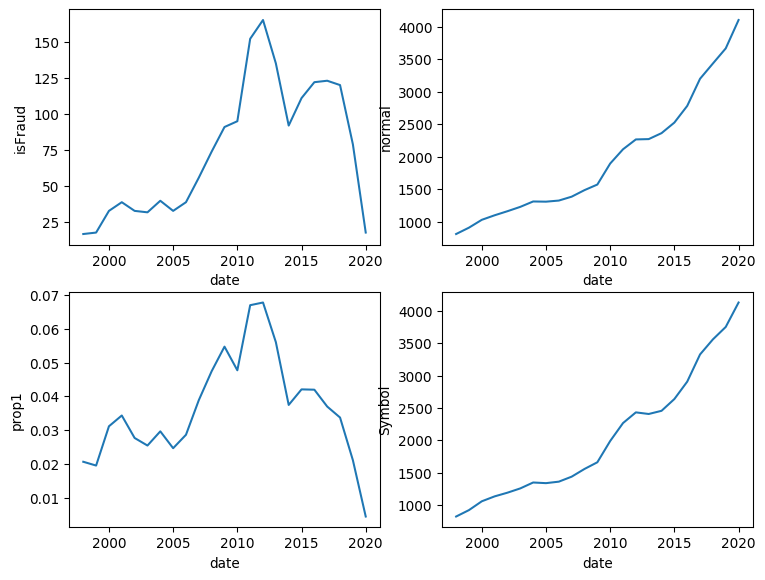

In [47]:
# Fraud year
fyear = final_data.groupby('date')['isFraud'].sum()
year = final_data.groupby('date')['Symbol'].count()
cc = pd.concat([fyear, year], axis=1)
cc['normal'] = cc['Symbol'] - cc['isFraud']
cc['prop1'] = cc['isFraud'] / cc['Symbol']
cc['prop2'] = cc['normal'] / cc['Symbol']

plt.figure(figsize=(9,7),dpi=98)
plt.subplot(2,2,1)
# 绘画折线图：
sns.lineplot(x=cc.index, y="isFraud", data=cc, ci=95)

plt.subplot(2,2,2)
sns.lineplot(x=cc.index, y="normal", data=cc, ci=95)

plt.subplot(2,2,3)
sns.lineplot(x=cc.index, y="prop1", data=cc, ci=95)

plt.subplot(2,2,4)
sns.lineplot(x=cc.index, y="Symbol", data=cc, ci=95)
# 显示
plt.show()

# 3) 问题3：对两类公司（欺诈类/非欺诈类）收集的28个财务指标做描述性统计，要求包含'Mean', 'SD', 'Skew', 'Kurt', 'Min', '5%', '25%', 'Median', '75%', '95%', 'Max', 'n'，对比两类公司的区别，两类公司的28个指标中是否存在显著差异

In [48]:
fraud_data = final_data.loc[final_data['isFraud'] == 1]
nfraud_data = final_data.loc[final_data['isFraud'] == 0]

def get_append(dataframe, end):
    flist = []
    nlist = list(dataframe.columns[2:end])
    for i in nlist:
        flist.append(pd.pivot_table(dataframe, index='Symbol', columns='date')[i])
    return flist, nlist   

fraud_list, fraud_name = get_append(fraud_data, 31)
nfraud_list, nfraud_name = get_append(nfraud_data, 31)

In [49]:
def statistic(list_of_data,name_of_data):
    X = pd.DataFrame()
    for i in range(len(list_of_data)):
        x = list_of_data[i]
        new = pd.Series([x.mean().mean(),x.std().mean(),x.skew().mean(),x.kurt().mean(),x.min().mean(),x.quantile(.05).mean(),x.quantile(.25).mean(),x.median().mean(),x.quantile(.75).mean(),x.quantile(.95).mean(),x.max().mean(),x.count().mean()],
                         index = ['Mean','SD','Skew','Kurt','Min','5%','25%','Median','75%','95%','Max','n'],name = name_of_data[i])
        X = pd.concat([X,new],axis=1)
    X = X.T
    X = X.applymap(lambda x:round(x, 2))
    return X

fraud_stat = statistic(fraud_list, fraud_name)
nfraud_stat = statistic(nfraud_list, nfraud_name)

fraud_stat


,Mean,SD,Skew,Kurt,Min,5%,25%,Median,75%,95%,Max,n
mkt,3.010567e+09,3.575052e+09,3.39,15.64,4.676879e+08,7.181370e+08,1.294604e+09,2.033778e+09,3.204564e+09,7.936698e+09,2.476544e+10,74.65
trading,3.093619e+07,6.917654e+07,5.65,42.62,1.000831e+04,1.186057e+04,1.781200e+06,5.784901e+06,2.574190e+07,1.421513e+08,3.615507e+08,81.62
receivable,4.581628e+08,7.114188e+08,3.12,13.90,9.874427e+06,2.395051e+07,9.619930e+07,2.256809e+08,4.993599e+08,1.580478e+09,4.608390e+09,77.00
inventory,6.682659e+08,1.797840e+09,4.55,29.35,9.817617e+05,1.599143e+07,8.502897e+07,2.158094e+08,5.013820e+08,2.386027e+09,1.473769e+10,76.73
casset,2.182612e+09,3.776303e+09,3.70,17.97,7.410104e+07,2.358095e+08,5.659631e+08,1.096325e+09,2.083110e+09,7.373931e+09,2.592878e+10,77.05
ppe,1.093414e+09,2.529337e+09,3.79,20.45,7.331424e+06,2.341842e+07,1.409912e+08,3.609970e+08,8.977694e+08,4.739233e+09,1.788611e+10,77.09
asset,4.198143e+09,6.892414e+09,3.50,16.66,1.654083e+08,4.498848e+08,1.107055e+09,2.157936e+09,4.161823e+09,1.404896e+10,4.773135e+10,77.14
payable,3.817924e+08,7.918015e+08,3.84,21.04,2.040060e+06,1.217635e+07,5.641624e+07,1.381788e+08,3.342971e+08,1.586329e+09,5.689629e+09,73.68
tax,3.717405e+07,1.117788e+08,1.72,15.64,-2.738510e+08,-2.002861e+07,3.721784e+06,1.426510e+07,4.070525e+07,1.788492e+08,7.393622e+08,77.09
cliability,1.943812e+09,3.703373e+09,3.76,19.26,3.873630e+07,1.130305e+08,3.436722e+08,8.394494e+08,1.861597e+09,6.780440e+09,2.637838e+10,77.05


In [42]:
nfraud_stat

,Mean,SD,Skew,Kurt,Min,5%,25%,Median,75%,95%,Max,n
mkt,6.342178e+09,2.765161e+10,13.57,280.63,1.929013e+08,5.971652e+08,1.317803e+09,2.282632e+09,4.477984e+09,1.767466e+10,7.782507e+11,1870.09
trading,4.863116e+09,2.255033e+10,16.11,403.19,3.065448e+07,6.031202e+07,1.817167e+08,5.207541e+08,3.194055e+09,1.306117e+10,3.075281e+11,1269.69
receivable,1.773425e+09,2.015216e+10,20.06,578.07,-1.744282e+08,1.259238e+07,8.069319e+07,2.043956e+08,4.925920e+08,2.309029e+09,6.663455e+11,1735.77
inventory,1.595293e+09,9.770814e+09,17.63,416.49,-1.729730e+05,8.422535e+06,8.914426e+07,2.452203e+08,6.794843e+08,4.733050e+09,2.359364e+11,1719.86
casset,4.460248e+09,1.982715e+10,15.27,332.01,5.054785e+06,2.162060e+08,5.880907e+08,1.184139e+09,2.626701e+09,1.370327e+10,4.536156e+11,1725.95
ppe,2.723025e+09,1.596953e+10,18.69,460.74,-1.545731e+07,3.412980e+07,1.755565e+08,4.290427e+08,1.163344e+09,8.440103e+09,4.308728e+11,1746.32
asset,4.104498e+10,4.574025e+11,18.82,408.95,4.068358e+07,4.879198e+08,1.150349e+09,2.342727e+09,5.820075e+09,4.432129e+10,1.167412e+13,1746.36
payable,1.137432e+09,7.225520e+09,16.89,377.52,4.777193e+04,1.062819e+07,5.914908e+07,1.636534e+08,4.903383e+08,3.153773e+09,1.737467e+11,1622.14
tax,1.951930e+08,1.784061e+09,18.08,429.00,-3.171026e+09,-2.579946e+07,3.906994e+06,1.559538e+07,5.002834e+07,4.028970e+08,4.521259e+10,1746.27
cliability,3.882913e+09,1.903400e+10,15.94,360.25,3.627911e+06,8.086606e+07,3.043724e+08,7.599359e+08,2.088559e+09,1.253611e+10,4.241854e+11,1725.91


In [50]:
def nwttest_1samp(a, lags=6):
    adj_a = np.array(a)
    # 对常数回归
    model = sm.OLS(adj_a, [1] * len(adj_a)).fit()
    return adj_a.mean(), float(model.tvalues)

def get_diff(fraud, nfraud, name):
    diff = pd.DataFrame()
    for i in range(len(fraud)):
        fdata = fraud[i].mean() - nfraud[i].mean()
        dif = pd.DataFrame(nwttest_1samp(fdata.dropna()))
        diff = pd.concat([diff, dif.T])
    diff.index = name
    return diff

fraud_diff = get_diff(fraud_list, nfraud_list, fraud_name)        
fraud_diff        
    

,0,1
mkt,-3.732607e+09,-5.201035
trading,-2.639587e+09,-2.684662
receivable,-1.283859e+09,-4.227296
inventory,-8.789571e+08,-4.652748
casset,-2.082532e+09,-4.707595
ppe,-1.455875e+09,-7.621459
asset,-3.051835e+10,-5.536058
payable,-6.860668e+08,-4.018312
tax,-1.357653e+08,-5.612472
cliability,-1.721916e+09,-4.738456


 # 4)	问题4：选择一家出现过财务违规和一家没有违规的公司，对该公司的财务数据进行分析
    
    000001 & 000004

In [15]:
f1 = final_data.loc[final_data['Symbol'] == 1]
nf4 = final_data.loc[final_data['Symbol'] == 4]

## 二、	Logit模型预测财务欺诈

对于因变量为binary信号(0 or 1)的计量问题，logit模型有着天然的优势。在这一部分我们采用Logit模型对上市公司财务欺诈进行识别，以上市公司是否发生财务欺诈作为因变量Ｙ，设Y=1为发生财务欺诈，Y=0为未发生财务欺诈。所有的自变量进行标准化处理。

对于因变量为binary信号(0 or 1)的计量问题，LR模型有着天然的优势。在这一部分我们采用Logestic模型对上市公司财务欺诈进行识别，以上市公司是否发生财务欺诈作为因变量Ｙ，设Y=1为发生财务欺诈，Y=0为未发生财务欺诈。所有的自变量进行标准化处理。

### A. 采用拓展窗口

使用最后6年的数据 2013–2018 作为测试集. 例如, 训练集是 1998–2011测试集则为 2013 and 1998–2013 测试 2015, 训练集和测试集期间进行2年的间隔.

### B. 最优超参数选择

采用网格调参的方式进行最优参数的筛选。LR参数主要调整优化算法，solver只有五个可选参数，即newton-cg,lbfgs,liblinear,sag,saga

 # 5) 问题5：对比两类数据（原始数据和财务比率）的AUC值
 
 # 6) 问题6：logit模型的结果中，哪些变量对于财务欺诈的预测有显著的作用


In [70]:
final_data.to_csv('final_data.csv')

In [51]:
final_list, final_name = get_append(final_data, 32)  #获取因子数据

In [33]:
final_name

['mkt',
 'trading',
 'receivable',
 'inventory',
 'casset',
 'ppe',
 'asset',
 'payable',
 'tax',
 'cliability',
 'equity',
 'trevenue',
 'cost',
 'otax',
 'oprofit',
 'tprofit',
 'profit',
 'ocf',
 'icf',
 'fcf',
 'cash',
 'acc',
 'ch_rec',
 'ch_inv',
 'soft_assets',
 'ch_cs',
 'ch_cm',
 'ch_roa',
 'bm',
 'isFraud']

In [84]:

def get_append(dataframe, end):
    flist = []
    nlist = list(dataframe.columns[2:end])
    lst = nlist.copy()
    for i in lst:
        df = pd.pivot_table(dataframe, index='Symbol', columns='date')[i]
        if len(df.columns) >= 20:
            flist.append(df)
        else:
            nlist.remove(i)
    return flist, nlist 

# 将因子值标准化为[-1,1]    
def get_med(df):
    new_df = pd.DataFrame(columns = df.columns, index = df.index)
    for i in df.columns:
        new_df.loc[:, i] = np.where(df[i]>=df[i].median(),(df[i] - df[i].median()) / (df[i].max() - df[i].median()), (df[i] - df[i].median()) / (df[i].median() - df[i].min()))
    new_df = new_df.fillna(0)
    return new_df

def get_trans(data):
    temp = []
    for i in range(len(data) - 1):
        df = data[i].copy()    

        new_df = get_med(df)
        temp.append(new_df)
    temp.append(data[-1])
    return temp


def get_fill(data):
    temp = []    
    for i in range(len(data)):
        df = data[i].copy()
        if len(df.columns) == 22:
            new_df = df
        else:
            copy = pd.DataFrame(columns = data[0].columns, index = data[0].index)
            for j in df.columns:
                copy[j] = df[j]
            copy = copy.fillna(0)
            new_df = copy
        temp.append(new_df)
    return temp               


def get_newdata(fac_data, fac_name):
    name = fac_name.copy()
    fac_name.append('date')
    bad = []
    timeseries = pd.DataFrame()

    for i in range(len(fac_data[0].columns)):
        fac95 = pd.DataFrame()
        for j in range(len(fac_data)):
            temp = fac_data[j].copy()
            fac95 = pd.concat([fac95, temp.iloc[:, i]], axis=1)     
        fac95['date'] = fac_data[0].columns[i]
        fac95.columns = fac_name  # 修改因子列名称
        timeseries = pd.concat([timeseries, fac95])
    return timeseries

os.chdir(r'D:\Postgraduate\2020\财务欺诈')
final_data = pd.read_csv('final_data.csv', index_col=0)
final_list, final_name = get_append(final_data, 32)  #获取因子数据
data_trans = get_trans(final_list)  # 进行标准化
data_fill = get_fill(data_trans)
data_ml = get_newdata(data_fill, final_name)

In [36]:
data_trans[1]  #部分数据从2006年才开始有样本

date,1998,2004,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Symbol,,,,,,,,,,,,,,,,
1,0.0,0.0,-1.0,0.011853,0.000472,0.018289,0.0,0.017134,0.019116,0.027972,0.062246,0.044978,0.117076,0.068379,0.180309,0.214881
2,0.0,0.0,0.0,0.000000,0.000000,0.000012,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014391,0.011994
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688368,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
688369,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
688388,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000744


In [70]:
data_ml

,mkt,trading,receivable,inventory,casset,ppe,asset,payable,tax,cliability,...,acc,ch_rec,ch_inv,soft_assets,ch_cs,ch_cm,ch_roa,bm,isFraud,date
1,1.000000,0.000000,0.127081,0.062024,0.000000,0.068194,1.000000,0.828646,0.274179,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.186587,0.0,1998
2,0.122098,0.000000,0.131453,0.296026,0.192860,0.000705,0.082514,0.190561,0.213385,0.216518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004161,0.0,1998
3,0.030445,0.000000,0.145284,0.165464,0.104453,0.043048,0.062278,0.170021,0.223089,0.297763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.118428,0.0,1998
4,-0.294840,0.000000,-0.435414,-0.986324,-0.689289,-0.448369,-0.623593,-0.864835,-0.073950,0.000998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.170480,0.0,1998
5,0.060341,0.000000,0.243537,-0.197618,0.038845,0.021986,0.030936,-0.301682,-0.075293,0.093731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.072438,0.0,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688368,-0.714482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2019
688369,-0.775229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2019
688388,-0.203090,0.000744,-0.760842,-0.611862,-0.112877,-0.297313,-0.432157,-0.909675,-0.789747,-0.968115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004697,0.0,2019
688389,-0.911775,0.000000,-0.980751,-0.884923,-0.610398,-0.841186,-0.754801,-0.834963,-0.780686,-0.921524,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027592,0.0,2019


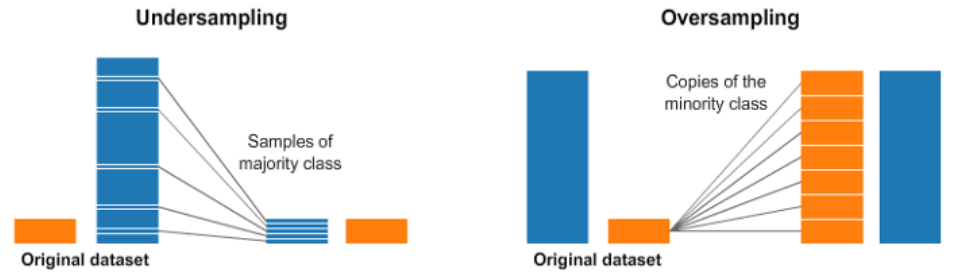

In [85]:
def get_CLF(train, i, start, end, models): 
    lr_params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    rus_params = {'learning_rate':[10 ** i for i in range(-3, 0)], 'n_estimators':[10 ** i for i in range(1, 4)]}       
    
    valids = train.loc[(train.date>i-2-int((i-2000)/5)) & (train.date<=i-2)]     
    trains = train.loc[train.date<=i-2-int((i-2000)/5)]
    
    y_trains = trains.isFraud
    x_trains = trains.iloc[:, start: end]
        
    y_valids = valids.isFraud
    x_valids = valids.iloc[:, start: end]
        
    if models == 'LR':
        maemax = 0.1
        j = 0
        while (j < 1):
            j = j + 1
            parameters = lr_params        
            for ne in parameters['solver']:
                clf = LR(solver = ne)
                clf.fit(x_trains,y_trains)
                prediction = clf.predict(x_valids)
                try:
                    mae = roc_auc_score(y_valids, prediction)
                except:
                    mae = maemax
                    neb = ne
                if mae>maemax:
                    maemax=mae
                    neb=ne                       
            lr_params = {'solver':[neb]}  
        CLF = LR(solver = neb)
        Params = {'solver': neb}
                        
    if models == 'RUS':
        maemax = 0.1
        j = 0
        while (j < 2):
            j = j + 1
            parameters = rus_params
            for ne in parameters['n_estimators']:
                for lr in parameters['learning_rate']:
                    clf = RUSBoostClassifier(n_estimators = ne, learning_rate = lr)
                    clf.fit(x_trains,y_trains)
                    PREDICTION = clf.predict(x_valids)
                    mae = roc_auc_score(y_valids, PREDICTION)
                    if mae>maemax:
                        maemax=mae
                        neb=ne
                        lrb = lr
            rus_params = {'n_estimators': [neb * i for i in range(1, 10)], 'learning_rate':[lrb * i for i in range(1, 4)]}  
        CLF = RUSBoostClassifier(n_estimators = neb, learning_rate = lrb)
        Params = {'n_estimators': neb, 'learning_rate': lrb}          

    return CLF, Params

In [77]:
# Predict the financial fraud with LR
def get_LR(start, end, data, models):
    '''
    @param start: 财务数据和比例的划分 
    @param end: 财务数据和比例的划分 
    @param data:数据集
    @return: auc
    '''
    auc1 = []
    accuracy = []
    feature = pd.DataFrame()
    prediction = pd.DataFrame()
    classifier = LR()
    #parameters = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    data = data.loc[data.date >= 2000]
    for i in range(2013, 2019):        
        #划分训练集和测试集
        test = data.loc[data.date==i].dropna()
        train = data.loc[data.date<=i-2].dropna()
        
        y_train = train.isFraud
        x_train = train.iloc[:, start: end]
    
        y_test = test.isFraud
        x_test = test.iloc[:, start: end]
        
        clf_model, best_params = get_CLF(train, i, start, end, models) 
        model = clf_model.fit(x_train, y_train)       
   
        if i - 2013 == 4:
            print(best_params)  # 第五期超参数
                        
        scores = model.score(x_test, y_test)
        accuracy.append(scores)
        y_pred = model.predict(x_test)
        
        pred = pd.DataFrame(y_pred, index = x_test.index)
        FINAL = pd.concat([pred, test.loc[:, ['isFraud', 'date']]], axis = 1)
        prediction = pd.concat([prediction, FINAL])
        
        coef = pd.DataFrame(model.coef_)
        feature = pd.concat([feature, coef])
        fpr,tpr,threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr,tpr)
        auc1.append(roc_auc)
    print(np.mean(auc1))
    print(np.mean(accuracy))
    feature.columns = x_train.columns
    prediction.columns = ['pred','true','date']
    return auc1, accuracy, feature, prediction

auc_raw, accu_raw, coef_raw, pred_raw = get_LR(0, 20, data_ml, 'LR')

{'solver': 'saga'}
0.5
0.9586144488138643


In [79]:
pred_raw

,pred,true,date
1,0.0,0.0,2013
2,0.0,0.0,2013
4,0.0,1.0,2013
5,0.0,0.0,2013
6,0.0,0.0,2013
...,...,...,...
603993,0.0,0.0,2018
603996,0.0,0.0,2018
603997,0.0,0.0,2018
603998,0.0,0.0,2018


In [80]:
coef_raw

,mkt,receivable,inventory,casset,ppe,asset,payable,tax,cliability,equity,trevenue,cost,otax,oprofit,tprofit,profit,ocf,icf,fcf,cash
0,-0.370491,-0.014827,-0.045684,0.270065,-0.233343,0.020352,-0.372443,-0.013712,0.795831,-0.480039,-0.549515,0.230870,-0.752849,-0.693978,-0.179026,-0.157750,-0.369286,-1.220980,-0.479952,0.316719
0,-0.463727,-0.085555,0.005344,0.308480,-0.244649,-0.025062,-0.297497,-0.081306,0.662018,-0.491480,-0.830307,0.484343,-0.440905,-0.623074,-0.159709,-0.125350,-0.303035,-0.934126,-0.499974,0.305453
0,-0.496618,-0.074321,0.017671,0.212432,-0.285549,0.015996,-0.306016,-0.031553,0.690501,-0.433238,-0.760928,0.430172,-0.434020,-0.677109,-0.178897,-0.213435,-0.353287,-1.047157,-0.602638,0.348858
0,-0.503069,-0.003381,0.025019,0.131562,-0.309287,0.041509,-0.338516,-0.064982,0.746019,-0.386705,-0.635431,0.323720,-0.352746,-0.696601,-0.253071,-0.242090,-0.363946,-0.934328,-0.605543,0.327705
0,-0.488952,0.006792,0.032350,0.094804,-0.350665,0.144660,-0.321744,-0.077234,0.760345,-0.466799,-0.716237,0.387953,-0.367737,-0.614889,-0.284049,-0.246513,-0.379349,-0.931505,-0.509522,0.313479
0,-0.424359,0.039101,0.030143,-0.022313,-0.427685,0.194235,-0.334387,-0.083600,0.894640,-0.161502,-0.911891,0.519846,-0.408615,-0.623947,-0.348379,-0.296133,-0.365634,-0.908803,-0.469635,0.317947


## 三、   机器学习预测财务欺诈

### A.  RUSBOOST模型与非平衡样本

欺诈样本中信息非常缺乏，财务欺诈的预测中最重要的问题就是样本不均衡。面对数以千计的上市公司，财务欺诈和违规的公司数量太少了。因此，除了使用Logit模型外，我们使用RUSBOOST模型来解决欺诈样本的非平衡问题。RUSBoost是AdaBoost的变体，它利用随机欠采样（RUS）解决类不平衡学习的问题(Seiffert et al., 2010)。 它的工作方式与AdaBoost几乎相同，除了在每次迭代中执行RUS来解决欺诈性和非欺诈性公司的不平衡。

### B.	采用扩展窗口进行训练

使用最后6年的数据 2013–2018 作为测试集. 例如, 训练集是 1998–2011测试集则为 2013 and 1998–2013 测试 2015, 训练集和测试集期间进行2年的间隔.

### C.	最优超参数选择

采用网格调参的方式进行最优参数的筛选。首先在大规模的范围筛选 learning_rate [0.01, 0.1, 1, 10, 100] and n_estimators with [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000].
在筛选出最优参数后我们再次进行进一步的筛选。例如,0.01是最优参数，那么在同等数量级的范围内我们再次进行网格调仓筛选[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]，同样的n_eatimators也进行相同的处理 500 [400, 450, 500, 550, 600]

 # 7) 问题7：第5期学习的最优超参数是多少？

### D.	AUC计算

# 8) 问题8：在机器学习中分别使用财务指标和财务数据进行财务欺诈预测得出预测的AUC值和平衡准确率，判断两者的学习效果，并绘制预测矩阵
 
# 9) 问题9：对比logit模型和RUSBOOST模型的预测效果，在给定公司的情况下，Logit模型和Rusboost模型的两种数据情形下预测的情况（只需举一个公司的例子）

## 五.	变量重要性

# 10) 问题10：采用feature_importance找出对于财务欺诈预测最为关键某些的变量，并画热力图表示

In [86]:
# Predict the financial fraud with Machine Learning 
def get_rus(start, end, data, models):
    '''
    @param start: 财务数据和比例的划分 
    @param end: 财务数据和比例的划分 
    @param data:数据集
    @return: feature importance
    '''
    auc1 = []
    accuracy = []
    feature = pd.DataFrame()
    prediction = pd.DataFrame()

    data = data.loc[data.date>=2000]
    for i in range(2013, 2019): 
        print(i)
        #划分训练集和测试集
        test = data.loc[data.date==i].dropna()
        train = data.loc[data.date<=i-2].dropna()
        
        y_train = train.isFraud
        x_train = train.iloc[:, start: end]
    
        y_test = test.isFraud
        x_test = test.iloc[:, start: end]
        
        clf_model, best_params = get_CLF(train, i, start, end, models) 
        model = clf_model.fit(x_train, y_train)       
   
        if i - 2013 == 4:
            print(best_params)  # 第五期超参数

        importance = pd.DataFrame(model.feature_importances_).T
        feature = pd.concat([feature, importance])
        y_pred = model.predict(x_test)
                 
        scores = model.score(x_test, y_test)
        accuracy.append(scores)
        pred = pd.DataFrame(y_pred, index = x_test.index)
        FINAL = pd.concat([pred, test.loc[:, ['isFraud', 'date']]], axis = 1)
        prediction = pd.concat([prediction, FINAL])
        fpr,tpr,threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr,tpr)
        auc1.append(roc_auc)
    print(np.mean(auc1))
    print(np.mean(accuracy))
    feature.columns = x_train.columns
    prediction.columns = ['pred','true','date']
    return auc1, accuracy, feature, prediction

rus_auc, rus_acc, rus_raw, pred_raw = get_rus(0, 20, data_ml, 'RUS')

2013
2014
2015
2016
2017
{'n_estimators': 4000, 'learning_rate': 0.03}
2018
0.5736826714629534
0.4472735365130316


In [ ]:
rus1, rus2, rus3, rus4 = get_rus(20, 26,  data_ml, 'RUS')   #财务比率

In [71]:
pred_raw

,pred,true,date
1,0.0,0.0,2013
2,0.0,0.0,2013
4,1.0,1.0,2013
5,0.0,0.0,2013
6,0.0,0.0,2013
...,...,...,...
603993,0.0,0.0,2018
603996,1.0,0.0,2018
603997,0.0,0.0,2018
603998,0.0,0.0,2018


<function matplotlib.pyplot.show(*args, **kw)>

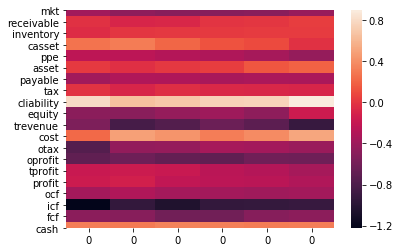

In [82]:
sns.heatmap(coef_raw.T)
plt.show